In [1]:
import sys
from os.path import join, abspath, pardir
from glob import glob
import numpy as np
import pandas as pd
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from time import time
from multiprocessing import Pool
import emcee
import corner
from scipy.stats import norm, uniform

In [2]:
root_dir = abspath(pardir)
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [3]:
dpi = 300
from utils import style
style()

In [4]:
root_data_dir = abspath(join(root_dir, "Data"))
data_dir = join(root_data_dir, "MCMC-2")
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution-2")
data_eff_dir = join(root_data_dir, "Effective-Volume-2")

In [5]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

In [6]:
# load data from files
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()

In [8]:
from utils import nu_mond, fw_mond

# Prototyping

In [7]:
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [53]:
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mond(zmid, **theta)
    Fw = fw_mond(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [51]:
def log_posterior_mond(theta, data, locs, scales, dim, norm_list, uni_list, simple=True):
    skip = 0 if simple else 24
    zdata, wdata = data
    theta_dict = dict(
        log_mu0=theta[skip+0],
        log_nu0=theta[skip+1],
        zsun=theta[skip+2],
        R=theta[skip+3],
        w0=theta[skip+4:skip+4+dim],
        log_sigma_w=theta[skip+4+dim:skip+4+2*dim],
        a=theta[skip+4+2*dim:skip+4+3*dim]
    )
    if not simple:
        theta_dict['rhos'] = theta[:12]
        theta_dict['sigmaz'] = theta[12:24]
    else:
        theta_dict['rhos'] = rhos
        theta_dict['sigmaz'] = sigmaz
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf
    
    theta_dict['mu0'] = np.exp(theta_dict['log_mu0'])
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

## utils

In [14]:
def load_data(index, number_files, velocity_files, velocity_popt_files):
    name = number_files[index].split('/')[-1]
    df_number = vaex.open(number_files[index])
    df_velocity = vaex.open(velocity_files[index])
    df_popt = vaex.open(velocity_popt_files[index])
    popt = df_popt['popt'].to_numpy()
    wdens= df_velocity['wnum'].to_numpy()
    werr = df_velocity['werr'].to_numpy()
    wmid = df_velocity['w'].to_numpy()
    dim = len(popt)//3

    zdens = df_number['density_corr'].to_numpy()
    zerr = df_number['density_err'].to_numpy()
    zmid = df_number['z'].to_numpy()

    w0 = []
    sigma_w = []
    a_raw = []

    for i in range(len(popt)//3):
        w0_i = popt[3*i+1]
        sigma_w_i = popt[3*i+2]
        a_raw_i = popt[3*i]
        
        w0.append(w0_i)
        sigma_w.append(sigma_w_i)
        a_raw.append(a_raw_i)

    w0 = np.array(w0)
    sigma_w = np.array(sigma_w)
    a_raw = np.array(a_raw)

    zdata = (zmid, zdens, zerr)
    wdata = (wmid, wdens, werr)
    data = (zdata, wdata)
    return data, dim, w0, sigma_w, a_raw, name

In [15]:
def plot_data(data, path=None):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata

    # plot 2 subplot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.')
    axes[0].set_xlabel(r'$z$ [pc]')
    axes[0].set_ylabel(r'$\rho(z)$ [pc$^{-3}$]')
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.')
    axes[1].set_xlabel(r'$w$ [km/s]')
    axes[1].set_ylabel(r'$f_w$')
    if path is not None:
        fig.savefig(path, dpi=dpi)
    fig.show()

In [56]:
def initialize_prior_mond(dim, w0, sigma_w, a_raw, simple=True):
    uni_list_DM = ['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
    norm_list_DM = ['R']
    
    locs = dict(
        log_mu0=np.log(0.1),
        log_nu0=np.log(1E-6), 
        zsun=-40, 
        R=3.4E-3, 
        w0=w0-20, 
        log_sigma_w=np.log(sigma_w*0.7), 
        a=a_raw*0.7
    )
    
    scales = dict(
        log_mu0=np.log(3)-locs['log_mu0'],
        log_nu0=np.log(1E-4)-locs['log_nu0'], 
        zsun=40-locs['zsun'], 
        R=0.6E-3, 
        w0=np.repeat(40, dim), 
        log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
        a=np.abs(a_raw*0.6)
    )
    if not simple:
        norm_list_DM += ['rhos', 'sigmaz']
        locs['rhos'] = rhos
        locs['sigmaz'] = sigmaz
        scales['rhos'] = e_rhos
        scales['sigmaz'] = e_sigmaz

    return locs, scales, uni_list_DM, norm_list_DM

In [18]:
def initialize_walkers_mond(locs, scales, dim, simple=True):
    theta = np.concatenate([np.ravel(x) for x in locs.values()])
    ndim = len(theta)
    nwalkers = ndim*2+1

    log_mu0_0 = np.random.uniform(low=locs['log_mu0'], high=locs['log_mu0']+scales['log_mu0'], size=nwalkers)
    log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
    zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
    R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
    w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
    log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
    a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

    p0 = []

    if not simple:
        rhos_0 = np.random.normal(loc=locs['rhos'], scale=scales['rhos'], size=(nwalkers, 12))
        sigmaz_0 = np.random.normal(loc=locs['sigmaz'], scale=scales['sigmaz'], size=(nwalkers, 12))
        p0 = np.array([*rhos_0.T, *sigmaz_0.T, log_mu0_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    else:
        p0 = np.array([log_mu0_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    return p0, ndim, nwalkers

In [93]:
def consume_samples_mond(samples_raw, dim, simple=True, flatten=False):
    skip = 0
    tot = 7
    labels = []
    if flatten:
        labels = [
            r"$\rho_{b}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\rho_{d}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\mu_0$", 
            r"$\nu_0\times 10^5 [$pc$^{-3}]$", 
            r"$z_{\odot}$ [pc]", 
            r"$R\times 10^3 [M_{\odot}$ pc$^{-3}]$",
            r"$w_0$ [km/s]",
            r"$\sigma_{w}$ [km/s]"]
    else:
        labels = [
            r"$\rho_{b}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\rho_{d}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
            r"$\log\ \mu_0$",
            r"$\log \nu_0\times [$pc$^{-3}]$", 
            r"$z_{\odot}$ [pc]", 
            r"$R\times 10^3 [M_{\odot}$ pc$^{-3}]$",
            r"$w_0$ [km/s]",
            r"$\log\ \sigma_{w}$ [km/s]"]
    rho_b = 0
    rho_d = 0
    if simple:
        labels = labels[1:]
    else:
        tot += 1
        rho_b = np.sum(samples_raw[:, :, 0:12], axis=2)
        skip = 24 
    sh = samples_raw.shape
    samples = np.concatenate((samples_raw, np.zeros((sh[0], sh[1], 1))), axis=2).copy()
    samples = samples[:, :, skip:skip+tot]
    w0 = samples_raw[:, :, skip+4:skip+4+dim]
    log_sigma_w = samples_raw[:, :, skip+4+dim:skip+4+2*dim]
    a = samples_raw[:, :, skip+4+2*dim:skip+4+3*dim]
    if simple:
        rho_d = np.sum(rhos)*(1/np.exp(samples[:, :, 0])-1)
    else:
        rho_d = rho_b*(1/np.exp(samples[:, :, 0])-1)
    samples[:, :, 3] = samples[:, :, 3]/1E-3 # R
    samples[:, :, 4] = np.average(w0, axis=2, weights=a) # w0
    
    if flatten:
        sigma_w = np.exp(log_sigma_w)
        samples[:, :, 0] = np.exp(samples[:, :, 0]) # mu0
        samples[:, :, 1] = np.exp(samples[:, :, 1])/1E-5 # nu0
        samples[:, :, 5] = np.average(sigma_w, axis=2, weights=a) # sigma_w
    else:
        samples[:, :, 5] = np.average(log_sigma_w, axis=2, weights=a) # sigma_w
    if not simple:
        # shift
        for i in range(tot-1,1, -1):
            samples[:, :, i] = samples[:, :, i-2]
        samples[:, :, 0] = rho_b/1E-2
        samples[:, :, 1] = rho_d/1E-2
    else:
        for i in range(tot-1,0, -1):
            samples[:, :, i] = samples[:, :, i-1]
        samples[:, :, 0] = rho_d/1E-2
    if flatten:
        samples = samples.reshape(-1, tot)
    return samples, labels

In [106]:
def plot_fitting_mond(sampler, data, dim, alpha=0.01, n=200, log=False, path=None, simple=True, dpi=150):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    # plot two subplot
    flat_samples = sampler.get_chain(flat=True).copy()
    zs = np.linspace(zmid.min(), zmid.max(), 100)
    ws = np.linspace(wmid.min(), wmid.max(), 100)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$\nu(z)$')
    axes[0].legend()
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
    axes[1].set_xlabel(r'w')
    axes[1].set_ylabel(r'fw')
    axes[1].legend()
    skip = 0 if simple else 24
    if log:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
    for i in tqdm(range(n)):
        index = np.random.randint(0, len(flat_samples))
        theta_dict = dict(
            mu0=np.exp(flat_samples[index, skip+0]),
            nu0=np.exp(flat_samples[index, skip+1]),
            zsun=flat_samples[index, skip+2],
            R=flat_samples[index, skip+3],
            w0=flat_samples[index, skip+4:skip+4+dim],
            sigma_w=np.exp(flat_samples[index, skip+4+dim:skip+4+2*dim]),
            a=flat_samples[index, skip+4+2*dim:skip+4+3*dim]
        )
        if not simple:
            theta_dict['rhos'] = flat_samples[index, :12]
            theta_dict['sigmaz'] = flat_samples[index, 12:24]
        else:
            theta_dict['rhos'] = rhos
            theta_dict['sigmaz'] = sigmaz
        nu = nu_mond(zs, **theta_dict)
        axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
        Fw = fw_mond(ws, **theta_dict)
        axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
    if path is not None:
        fig.savefig(path, dpi=dpi)
    fig.show()

In [22]:
def get_dataframe_mond(sampler_new, dim, locs, scales, norm_list_DM, uni_list_DM, nwalkers, simple=True):
    flat_samples = sampler_new.get_chain().copy()
    log_posterior_chain = sampler_new.get_log_prob().copy()
    thetas = []
    t0 = time()
    skip = 0 if simple else 24
    for i, post in enumerate(log_posterior_chain.T):
        for samples, lg_posterior in zip(tqdm(flat_samples[:, i], desc=f"{i}/{nwalkers}", leave=False), post):
            theta = {
                "log_mu0": samples[skip+0],
                "log_nu0": samples[skip+1],
                "zsun": samples[skip+2],
                "R": samples[skip+3],
                "w0": samples[skip+4:skip+4+dim],
                "log_sigma_w": samples[skip+4+dim:skip+4+2*dim],
                "a": samples[skip+4+2*dim:skip+4+3*dim]
            }
            if simple:
                theta['rhos'] = rhos
                theta['sigmaz'] = sigmaz
            else:
                theta['rhos'] = samples[:12]
                theta['sigmaz'] = samples[12:24]
            lg_prior = log_prior(theta, locs, scales, norm_list_DM, uni_list_DM)
            theta['log_prior'] = lg_prior
            theta['log_posterior'] = lg_posterior
            theta['log_likelihood'] = lg_posterior - lg_prior
            del theta['w0'], theta['log_sigma_w'], theta['a'], theta['rhos'], theta['sigmaz']
            for j in range(dim):
                theta[f"w0_{j}"] = samples[skip+4+j]
                theta[f"log_sigma_w_{j}"] = samples[skip+4+dim+j]
                theta[f"a_{j}"] = samples[skip+4+2*dim+j]
            if not simple:
                for j in range(12):
                    theta[f"rhob_{j}"] = samples[j]
                    theta[f"sigmaz_{j}"] = samples[12+j]
            theta['walker'] = i
            thetas.append(theta)
    t1 = time()
    print(f"Time: {t1-t0:.2f} s")
    df = pd.DataFrame(thetas)
    ## save
    df_dm = vaex.from_pandas(df)
    return df_dm

# Let' begin

gaia_(0.10)_(0.14).hdf5


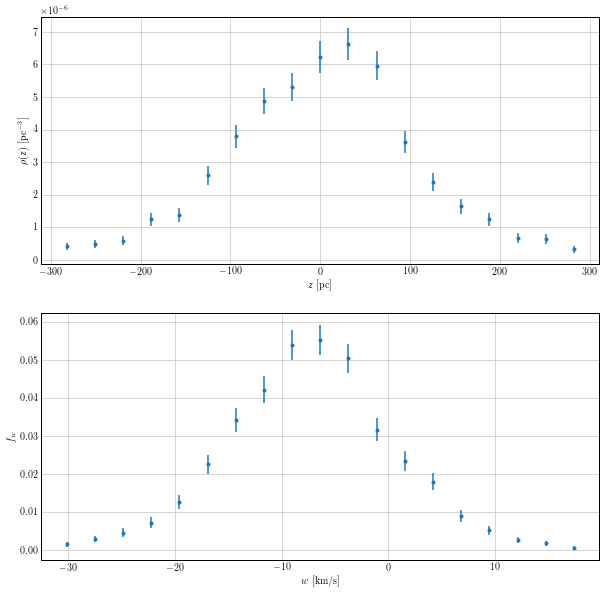

In [23]:
index = 2
data, dim, w0, sigma_w, a_raw, name = load_data(index, number_files, velocity_files, velocity_popt_files)
print(name)
## plot data
plot_data(data)

## simple

In [57]:
## initialize prior
simple = True
cores = 16
locs, scales, uni_list, norm_list = initialize_prior_mond(dim, w0, sigma_w, a_raw, simple=simple)
locs, scales, uni_list, norm_list

({'log_mu0': -2.3025850929940455,
  'log_nu0': -13.815510557964274,
  'zsun': -40,
  'R': 0.0034,
  'w0': array([-26.64731666]),
  'log_sigma_w': array([1.49998847]),
  'a': array([0.67074305])},
 {'log_mu0': 3.401197381662155,
  'log_nu0': 4.605170185988092,
  'zsun': 80,
  'R': 0.0006,
  'w0': array([40]),
  'log_sigma_w': array([0.61903921]),
  'a': array([0.57492262])},
 ['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R'])

In [58]:
## initialize walkers
p0, ndim, nwalkers = initialize_walkers_mond(locs, scales, dim, simple=simple)
p0.shape, ndim, nwalkers

((15, 7), 7, 15)

In [59]:
uni_list, norm_list

(['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'], ['R'])

In [60]:
for p00 in p0:
    res = log_posterior_mond(p00, data, locs, scales, dim, norm_list, uni_list, simple=simple)
    print(res)

-29589.901287196248
-3697.2606391041477
-5527.974514384553
-3040.8598470842658
-27527.755641104828
-19732.50305790603
-4538.44889394982
-261.7433333070498
-9973.203367259257
-20757.71297124162
-299498.11784982384
-293.37734176514425
-2573.0744384171126
-437.87456261492684
-11822.178511943253


100%|██████████| 500/500 [00:33<00:00, 14.73it/s]


Multiprocessing took 34.1 seconds


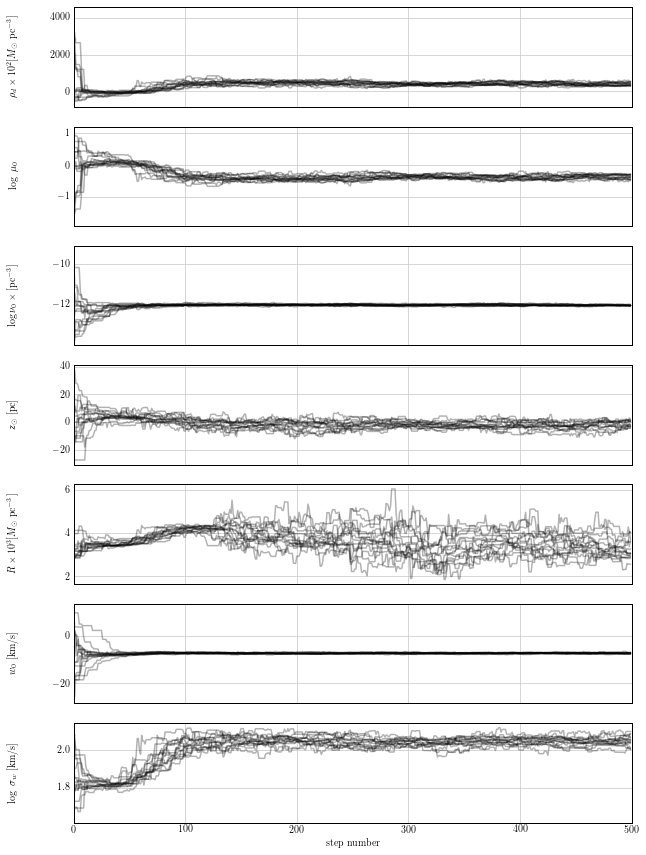

In [64]:
from utils import run_mcmc

sampler = run_mcmc(
    nwalkers, ndim, p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=500, simple=simple
)

100%|██████████| 2000/2000 [02:09<00:00, 15.46it/s]


Multiprocessing took 129.5 seconds


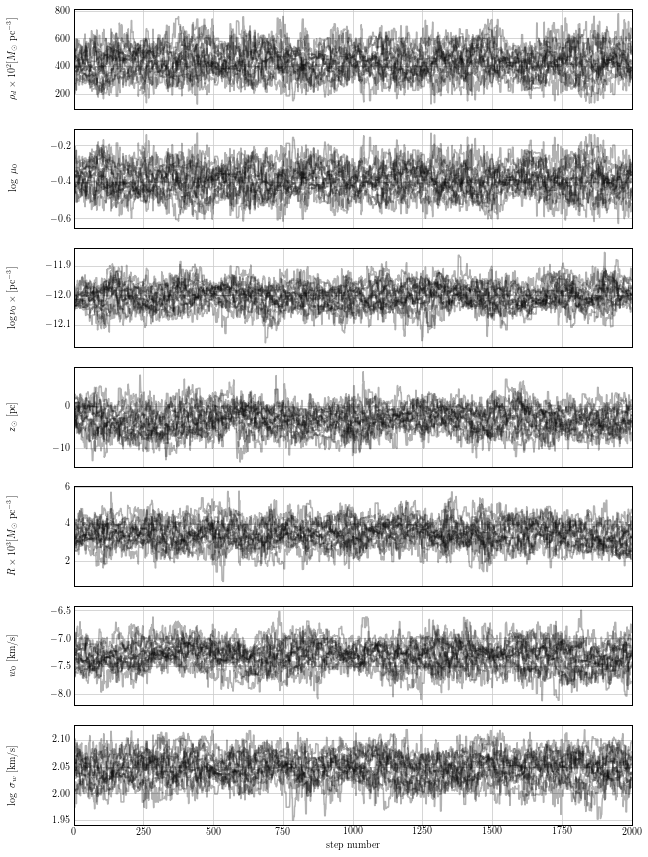

In [65]:
## run again, with the last sample as the initial point
next_p0 = sampler.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=2000, simple=simple
)

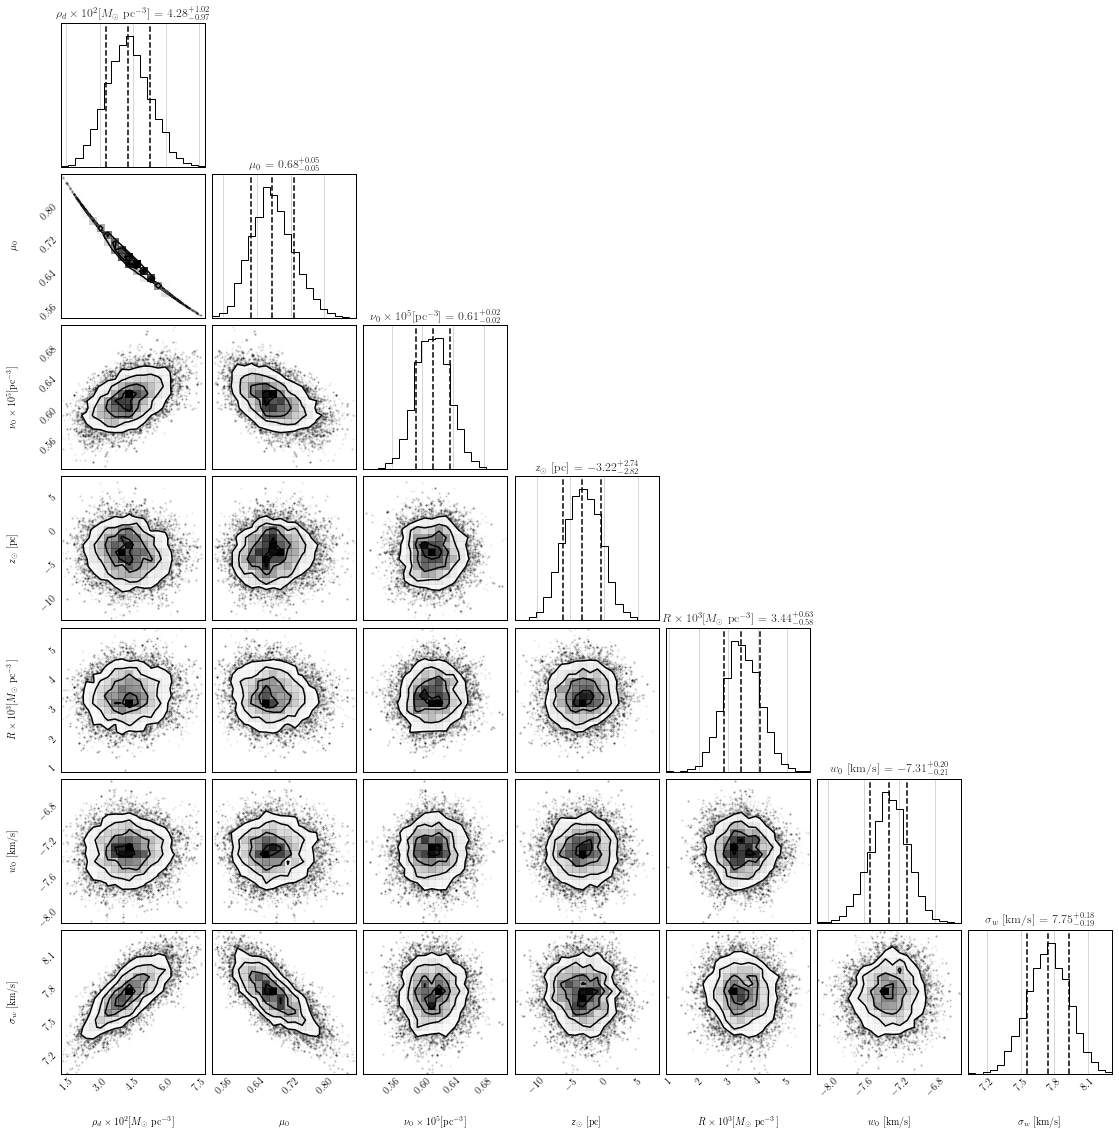

In [67]:
from utils import plot_corner

samples = sampler_new.get_chain()
plot_corner(samples, dim, consume_samples_mond)

100%|██████████| 500/500 [00:11<00:00, 43.67it/s]


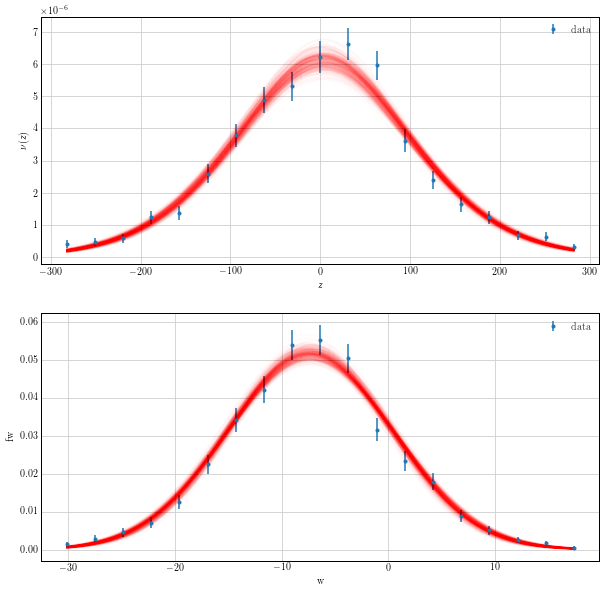

In [70]:
plot_fitting_mond(sampler_new, data, dim, alpha=0.01, n=500)

In [71]:
df = get_dataframe_mond(sampler_new, dim, locs, scales, norm_list, uni_list, nwalkers, simple=simple)
df

Time: 30.34 s


#,log_mu0,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,walker
0,-0.4420306134634382,-12.03461771880997,-1.5524737870798233,0.0032738752309986554,-3.311558081639462,350.55409725642994,353.8656553380694,-7.223615342437056,2.084739786203352,0.7878378841756533,0
1,-0.4420306134634382,-12.03461771880997,-1.5524737870798233,0.0032738752309986554,-3.311558081639462,350.55409725642994,353.8656553380694,-7.223615342437056,2.084739786203352,0.7878378841756533,0
2,-0.4420306134634382,-12.03461771880997,-1.5524737870798233,0.0032738752309986554,-3.311558081639462,350.55409725642994,353.8656553380694,-7.223615342437056,2.084739786203352,0.7878378841756533,0
3,-0.5112950340496303,-12.030781977120132,-2.7418854379454647,0.002810710806790943,-3.7717723814690984,347.5004952121607,351.27226759362975,-7.022824823752331,2.101643859115442,0.6772439505546282,0
4,-0.5112950340496303,-12.030781977120132,-2.7418854379454647,0.002810710806790943,-3.7717723814690984,347.5004952121607,351.27226759362975,-7.022824823752331,2.101643859115442,0.6772439505546282,0
...,...,...,...,...,...,...,...,...,...,...,...
"29,995",-0.40335543893810033,-11.994384788550908,-0.47579422927499565,0.002502503016979474,-4.408215549938495,349.89789045160904,354.30610600154756,-7.539005153787154,2.0359799374637704,1.2230970559003187,14
"29,996",-0.40335543893810033,-11.994384788550908,-0.47579422927499565,0.002502503016979474,-4.408215549938495,349.89789045160904,354.30610600154756,-7.539005153787154,2.0359799374637704,1.2230970559003187,14
"29,997",-0.40335543893810033,-11.994384788550908,-0.47579422927499565,0.002502503016979474,-4.408215549938495,349.89789045160904,354.30610600154756,-7.539005153787154,2.0359799374637704,1.2230970559003187,14
"29,998",-0.3827432356269772,-11.998241238284269,-0.8186989156624069,0.0026616694943480896,-4.046592079168022,351.1541697531693,355.2007618323373,-7.485489048487694,2.0398764449669415,1.209653527433051,14


find $a_0$ for given interpolation function

**Simple**
\begin{aligned}
    \mu(x) &= \frac{x}{1+x} \\
    x &= \frac{\mu}{1-\mu}
\end{aligned}

**Standard**
\begin{aligned}
    \mu(x) &= \sqrt{\frac{x^2}{1+x^2}} \\
    x &= \frac{\mu}{\sqrt{1-\mu^2}}
\end{aligned}

In [72]:
def inv_interpolation_simple(mu):
    return mu/(1-mu)

def inv_interpolation_standard(mu):
    return mu/np.sqrt(1-mu**2)

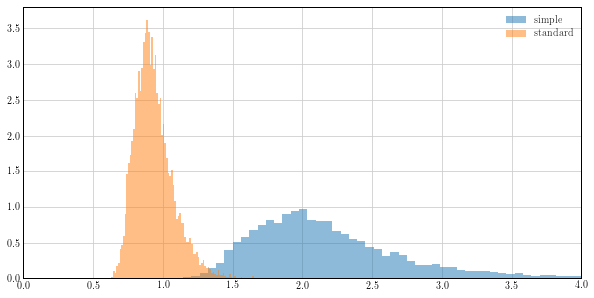

In [75]:
log_mu0 = df['log_mu0'].to_numpy()
mu0 = np.exp(log_mu0)

a0_simple = inv_interpolation_simple(mu0)
a0_standard = inv_interpolation_standard(mu0)

plt.figure(figsize=(10, 5))
plt.hist(a0_simple, bins=100, label="simple", alpha=0.5, density=True)
plt.hist(a0_standard, bins=100, label="standard", alpha=0.5, density=True)
plt.legend()
plt.xlim(0, 4)
plt.show()

## full

In [76]:
## initialize prior
simple = False
cores = 16
locs, scales, uni_list, norm_list = initialize_prior_mond(dim, w0, sigma_w, a_raw, simple=simple)
locs, scales, uni_list, norm_list

({'log_mu0': -2.3025850929940455,
  'log_nu0': -13.815510557964274,
  'zsun': -40,
  'R': 0.0034,
  'w0': array([-26.64731666]),
  'log_sigma_w': array([1.49998847]),
  'a': array([0.67074305]),
  'rhos': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
         0.0072, 0.0216, 0.0056, 0.0015]),
  'sigmaz': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
         20. ])},
 {'log_mu0': 3.401197381662155,
  'log_nu0': 4.605170185988092,
  'zsun': 80,
  'R': 0.0006,
  'w0': array([40]),
  'log_sigma_w': array([0.61903921]),
  'a': array([0.57492262]),
  'rhos': array([3.12e-03, 5.54e-03, 7.00e-04, 3.00e-05, 6.00e-05, 1.80e-04,
         1.80e-04, 2.90e-04, 7.20e-04, 2.80e-03, 1.00e-03, 5.00e-04]),
  'sigmaz': array([0.2, 0.5, 2.4, 4. , 1.6, 2. , 2.4, 1.8, 1.9, 4. , 5. , 5. ])},
 ['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R', 'rhos', 'sigmaz'])

In [77]:
## initialize walkers
p0, ndim, nwalkers = initialize_walkers_mond(locs, scales, dim, simple=simple)
p0.shape, ndim, nwalkers

((63, 31), 31, 63)

In [78]:
uni_list, norm_list

(['log_mu0', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R', 'rhos', 'sigmaz'])

In [79]:
for p00 in p0:
    res = log_posterior_mond(p00, data, locs, scales, dim, norm_list, uni_list, simple=simple)
    if np.isnan(res):
        print(p00)

100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Multiprocessing took 72.1 seconds


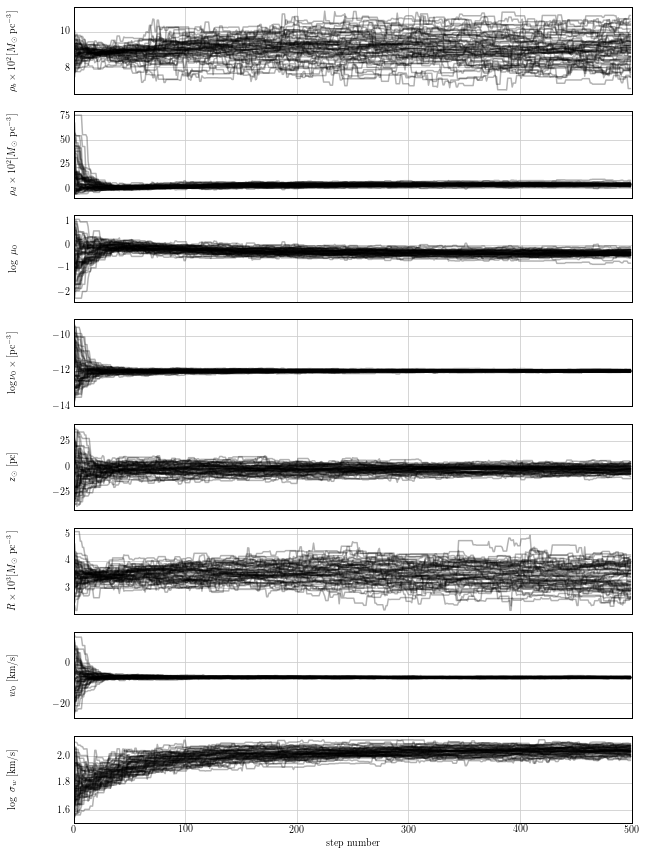

In [94]:
from utils import run_mcmc

sampler = run_mcmc(
    nwalkers, ndim, p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=500, simple=simple
)

100%|██████████| 2000/2000 [04:33<00:00,  7.32it/s]


Multiprocessing took 273.4 seconds


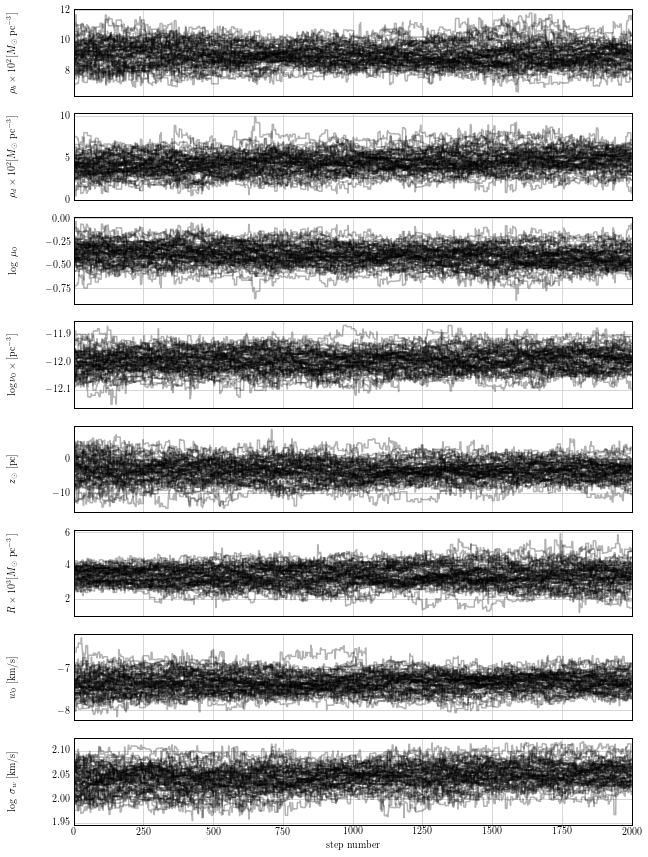

In [95]:
## run again, with the last sample as the initial point
next_p0 = sampler.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, dim, log_posterior_mond, consume_samples_mond, cores=cores,
    args=[data, locs, scales, dim, norm_list, uni_list, simple], 
    plot=True, step=2000, simple=simple
)

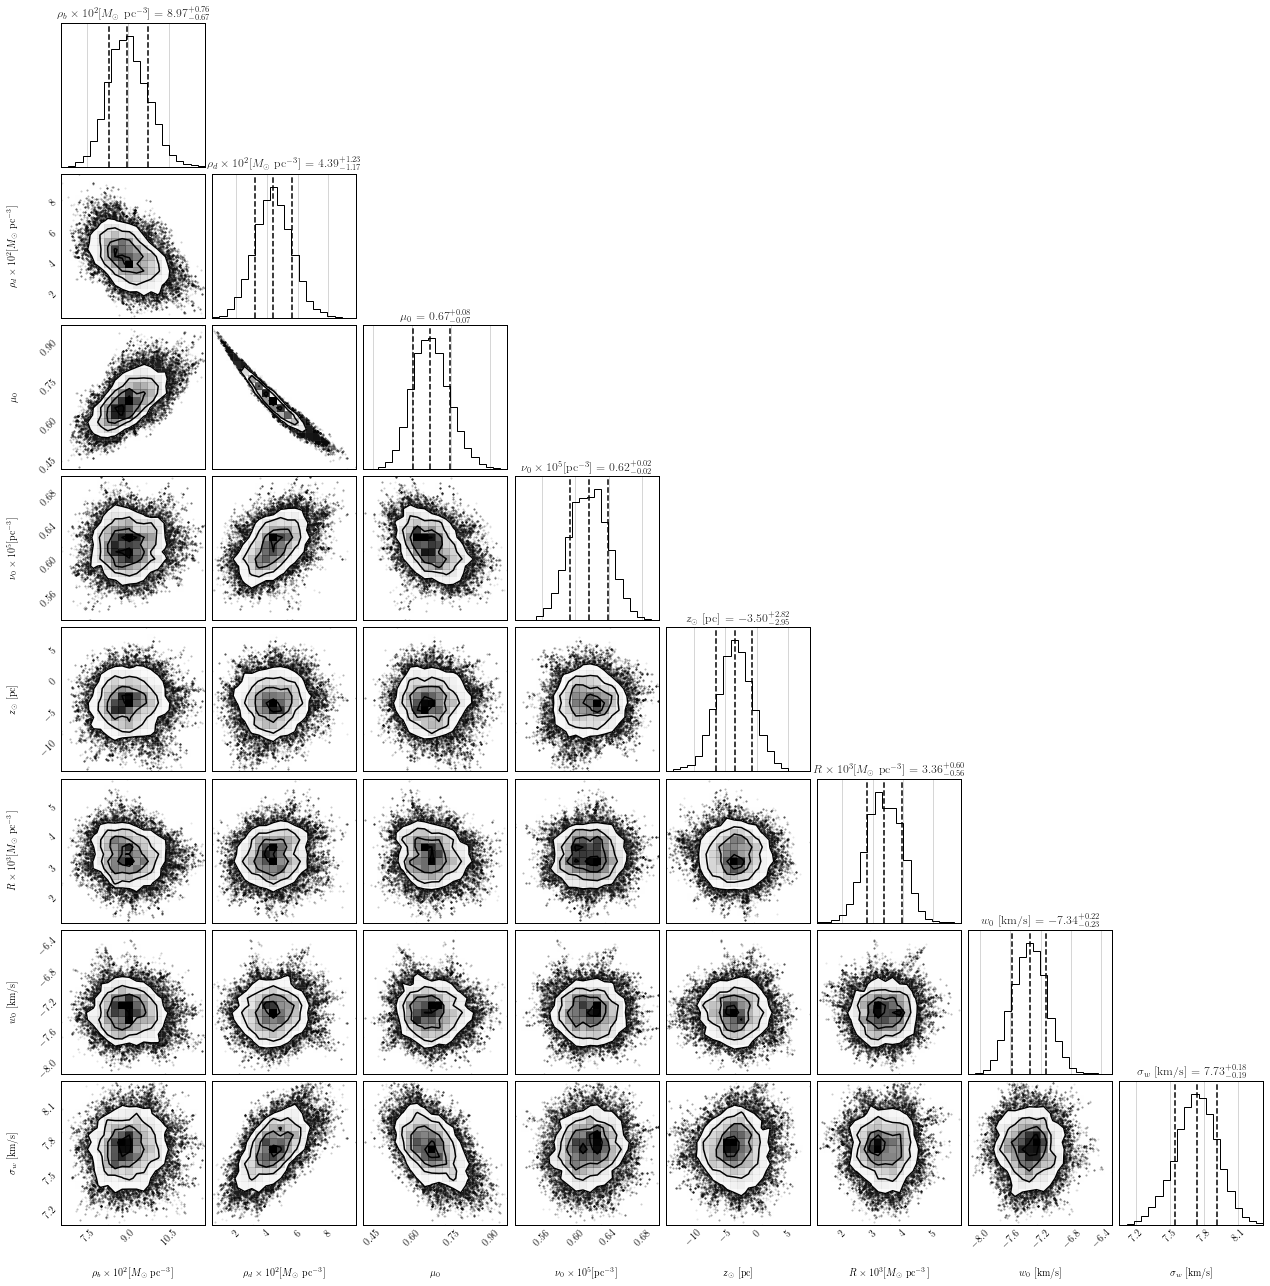

In [97]:
from utils import plot_corner

samples = sampler_new.get_chain()
plot_corner(samples, dim, consume_samples_mond, simple=simple)

100%|██████████| 500/500 [00:11<00:00, 43.20it/s]


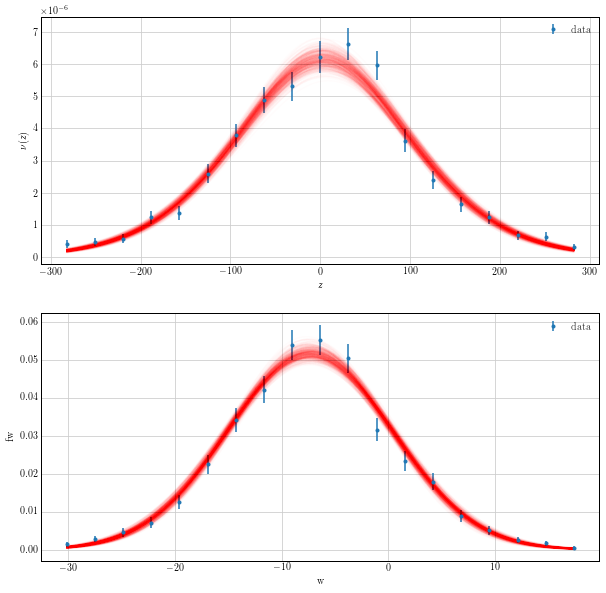

In [108]:
plot_fitting_mond(sampler_new, data, dim, alpha=0.01, n=500, simple=simple)

In [109]:
df = get_dataframe_mond(sampler_new, dim, locs, scales, norm_list, uni_list, nwalkers, simple=simple)
df

Time: 157.18 s


#,log_mu0,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,rhob_0,sigmaz_0,rhob_1,sigmaz_1,rhob_2,sigmaz_2,rhob_3,sigmaz_3,rhob_4,sigmaz_4,rhob_5,sigmaz_5,rhob_6,sigmaz_6,rhob_7,sigmaz_7,rhob_8,sigmaz_8,rhob_9,sigmaz_9,rhob_10,sigmaz_10,rhob_11,sigmaz_11,walker
0,-0.26111578782261113,-12.035520967947186,2.8868057460369396,0.004001091191269398,50.76142017296605,400.85176373014156,350.0903435571755,-7.266935044763753,1.9918770889727804,1.1287514991567216,0.008255591084470344,3.7496175538300465,0.027771186310128787,7.678717201440844,0.007440066727977452,20.284949910203075,0.00048448322647765213,35.30381398768861,0.0004854752138745306,15.494774107401781,0.001656792876152128,7.126488720722134,0.0016796726078009722,11.911693496936335,0.003206381790303455,14.989758370789751,0.006867056953204704,18.157228991922437,0.022107371006121812,21.553929269935857,0.005458835232616645,17.284400588123066,0.0016879529420108326,22.651800930584194,0
1,-0.25401484889300574,-12.046814644188805,3.440991302394001,0.004080311017806124,48.948573081427504,398.2274945243863,349.2789214429588,-7.238253885906551,1.9912890758183615,1.1274569861320514,0.007782363931472228,3.7761847105534305,0.0272363739788377,7.829164639560769,0.007401574013373236,20.07159094842875,0.00048118850916162846,35.09353153415348,0.0004737180420561698,15.423211756363399,0.0016253636977423057,7.181822178131414,0.001652598295062338,11.77311378369516,0.0032298759831064293,14.787732806681676,0.0068350144612795635,18.227319061109817,0.021935561757469708,21.714350889259123,0.005467623638114175,17.5244225697093,0.0016465972196976187,22.80421143281733,0
2,-0.25401484889300574,-12.046814644188805,3.440991302394001,0.004080311017806124,48.948573081427504,398.2274945243863,349.2789214429588,-7.238253885906551,1.9912890758183615,1.1274569861320514,0.007782363931472228,3.7761847105534305,0.0272363739788377,7.829164639560769,0.007401574013373236,20.07159094842875,0.00048118850916162846,35.09353153415348,0.0004737180420561698,15.423211756363399,0.0016253636977423057,7.181822178131414,0.001652598295062338,11.77311378369516,0.0032298759831064293,14.787732806681676,0.0068350144612795635,18.227319061109817,0.021935561757469708,21.714350889259123,0.005467623638114175,17.5244225697093,0.0016465972196976187,22.80421143281733,0
3,-0.25401484889300574,-12.046814644188805,3.440991302394001,0.004080311017806124,48.948573081427504,398.2274945243863,349.2789214429588,-7.238253885906551,1.9912890758183615,1.1274569861320514,0.007782363931472228,3.7761847105534305,0.0272363739788377,7.829164639560769,0.007401574013373236,20.07159094842875,0.00048118850916162846,35.09353153415348,0.0004737180420561698,15.423211756363399,0.0016253636977423057,7.181822178131414,0.001652598295062338,11.77311378369516,0.0032298759831064293,14.787732806681676,0.0068350144612795635,18.227319061109817,0.021935561757469708,21.714350889259123,0.005467623638114175,17.5244225697093,0.0016465972196976187,22.80421143281733,0
4,-0.25401484889300574,-12.046814644188805,3.440991302394001,0.004080311017806124,48.948573081427504,398.2274945243863,349.2789214429588,-7.238253885906551,1.9912890758183615,1.1274569861320514,0.007782363931472228,3.7761847105534305,0.0272363739788377,7.829164639560769,0.007401574013373236,20.07159094842875,0.00048118850916162846,35.09353153415348,0.0004737180420561698,15.423211756363399,0.0016253636977423057,7.181822178131414,0.001652598295062338,11.77311378369516,0.0032298759831064293,14.787732806681676,0.0068350144612795635,18.227319061109817,0.021935561757469708,21.714350889259123,0.005467623638114175,17.5244225697093,0.0016465972196976187,22.80421143281733,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"125,995",-0.24563681498572507,-11.938202897867233,-4.628908321911024,0.0030848400413116006,45.82731942334116,398.7547533830555,352.92743395971434,-6.972212708596276,2.043552527830823,0.803530288

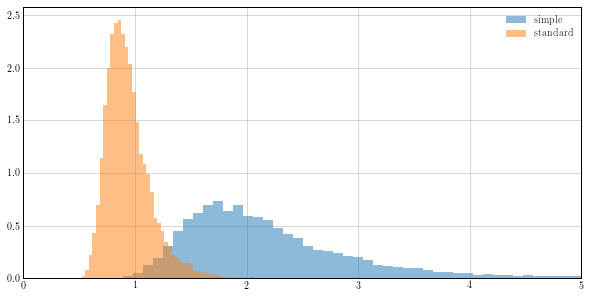

In [119]:
log_mu0 = df['log_mu0'].to_numpy()
mu0 = np.exp(log_mu0)

a0_simple = inv_interpolation_simple(mu0)
a0_standard = inv_interpolation_standard(mu0)

plt.figure(figsize=(10, 5))
plt.hist(a0_simple, bins=300, label="simple", alpha=0.5, density=True)
plt.hist(a0_standard, bins=100, label="standard", alpha=0.5, density=True)
plt.legend()
plt.xlim(0, 5)
plt.show()